# Background

- I recall studying temperatures where the magnet trips, but I don't remember exactly what temperature that was.
- Using this notebook for refreshing myself on this issue.
- Compare also to GMW manual:
    - Interlocks 3 and 4 are both "Overtemperature: Normally closed. Open when coil temperature exceeds 50 deg C" (PDF page 5, manual page 1-2)
- Result (see below):

From Mar 2019 trip, we see the coil temperatures slowly rise to >50 deg C. Ultimately the magnet trips with Coil 1 (2) temperatures of 59 deg C (57.5 deg C). Note Coil 1 was replaced in 

# Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from copy import deepcopy
import pickle as pkl
from collections.abc import Iterable
# from datetime import datetime
from datetime import datetime, timedelta
# from pandas.api.types import is_numeric_dtype
from scipy.interpolate import interp1d
from scipy.spatial.transform import Rotation
import lmfit as lm
# from copy import deepcopy
#from dateutil import parser
from plotly import graph_objects as go
from plotly.offline import plot
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
# from plotting import config_plots, datetime_plt, get_label
from plotting import config_plots, get_label
from load_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d, scatter2d, histo, spherical_scatter3d
from mu2e.mu2eplots import mu2e_plot3d
# V vs. B, T (2021 results)
from V_vs_B_T import V_forward, inv_B_v2, invert_row, calc_B_column

config_plots()
# plt.rcParams.update({"text.usetex": True})

# Functions

# Main

## Temp when tripping (mean)

- Looking through emails:
- Sep 2020 (no slow controls so no temperatures...)
    - Sep 10, 2020 (magnet tripped evening Sep 9)
    - Sep 11, 2020 (magnet tripped evening Sep 10)
- Mar 2020
    - Mar 19, 13:43 Thomas reports PS ramped down
(older chiller arrived Dec 12, 2019)
- Jul 2019
    - Trip July 2 evening (~21:00)
- Jun 2019
    - Trip June 26 evening (17:00)

In [59]:
ddir = '/home/ckampa/Dropbox/LogFiles/'

In [115]:
#slowfile = ddir + '2020-03-16 124657slow.txt' # Mar 2020 -- no clear sign of high temp
# slowfile = ddir + '2019-07-02 151328slow.txt' # Jul 2019
slowfile = ddir + '2019-06-24 080033slow.txt' # Jun 2019

In [116]:
# temperature
df = load_data(slowfile)

In [117]:
df

,Time,Magnet Current [V],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,Zaber_Meas_MicroStep_Y,Zaber_Meas_Encoder_Y,Zaber_Meas_MicroStep_Z,Zaber_Meas_Encoder_Z,seconds_delta,hours_delta,days_delta,magnet_X_mm,magnet_Y_mm,magnet_Z_mm
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-06-24 08:01:12,6/24/2019 8:01:12 AM,8.472841,38.376217,57.247688,54.508316,25.110586,29.081367,28.608168,34.339409,28.427599,...,178906.25,458000.0,642578.125,1645000.0,0.0,0.000000,0.000000,56.333594,140.940234,126.076172
2019-06-24 08:02:12,6/24/2019 8:02:12 AM,8.472839,38.376617,57.314743,54.573673,25.095934,29.078375,28.457365,34.357475,28.424211,...,178906.25,458000.0,642578.125,1645000.0,60.0,0.016667,0.000694,56.333594,140.940234,126.076172
2019-06-24 08:03:12,6/24/2019 8:03:12 AM,8.472841,38.376833,57.233330,54.601650,25.080084,29.084125,28.486698,34.348522,28.416948,...,178906.25,458000.0,642578.125,1645000.0,120.0,0.033333,0.001389,56.333594,140.940234,126.076172
2019-06-24 08:04:12,6/24/2019 8:04:12 AM,8.472840,38.377150,57.340321,54.618118,25.062561,29.029978,28.548357,34.307186,28.429863,...,178906.25,458000.0,642578.125,1645000.0,180.0,0.050000,0.002083,56.333594,140.940234,126.076172
2019-06-24 08:05:12,6/24/2019 8:05:12 AM,8.472839,38.377283,57.413399,54.598812,25.061321,29.042461,28.451517,34.322865,28.435728,...,178906.25,458000.0,642578.125,1645000.0,240.0,0.066667,0.002778,56.333594,140.940234,126.076172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26 14:50:26,6/26/2019 2:50:26 PM,-0.000092,-0.000006,20.746340,20.760599,21.476431,21.430735,20.352356,21.116384,18.259869,...,178906.25,458000.0,642578.125,1645000.0,197354.0,54.820556,2.284190,56.333594,140.940234,126.076172
2019-06-26 14:51:26,6/26/2019 2:51:26 PM,-0.000092,-0.000007,20.730684,20.756691,21.473247,21.415647,20.314943,21.117975,18.265778,...,178906.25,458000.0,642578.125,1645000.0,197414.0,54.837222,2.284884,56.333594,140.940234,126.076172
2019-06-26 14:52:25,6/26/2019 2:52:25 PM,-0.000092,-0.000006,20.731295,20.759970,21.484171,21.429184,20.330595,21.112829,18.268230,...,178906.25,458000.0,642578.125,1645000.0,197473.0,54.853611,2.285567,56.333594,140.940234,126.076172


In [118]:
df.index

DatetimeIndex(['2019-06-24 08:01:12', '2019-06-24 08:02:12',
               '2019-06-24 08:03:12', '2019-06-24 08:04:12',
               '2019-06-24 08:05:12', '2019-06-24 08:06:12',
               '2019-06-24 08:07:12', '2019-06-24 08:08:12',
               '2019-06-24 08:09:12', '2019-06-24 08:10:13',
               ...
               '2019-06-26 14:45:26', '2019-06-26 14:46:26',
               '2019-06-26 14:47:26', '2019-06-26 14:48:25',
               '2019-06-26 14:49:26', '2019-06-26 14:50:26',
               '2019-06-26 14:51:26', '2019-06-26 14:52:25',
               '2019-06-26 14:53:26', '2019-06-26 14:54:26'],
              dtype='datetime64[ns]', name='Datetime', length=3294, freq=None)

In [122]:
# Mar 2020
# t0 = '2020-03-18 13:00'
# tf = '2020-03-18 17:00'
# Jul 2019
#t0 = '2019-07-02 00:00' # see warm up
# t0 = '2019-07-02 16:00' # zoomed
# tf = '2019-07-03 00:00'
# Jun 2019
# t0 = '2019-06-24 00:00' # see warm up
t0 = '2019-06-25 12:00' # zoomed
tf = '2019-06-25 22:00'

In [123]:
df_ = df.query(f'"{t0}" <= Datetime <= "{tf}"').copy()

In [124]:
df_

,Time,Magnet Current [V],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,Zaber_Meas_MicroStep_Y,Zaber_Meas_Encoder_Y,Zaber_Meas_MicroStep_Z,Zaber_Meas_Encoder_Z,seconds_delta,hours_delta,days_delta,magnet_X_mm,magnet_Y_mm,magnet_Z_mm
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-06-25 12:00:14,6/25/2019 12:00:14 PM,8.472839,38.416500,57.580368,54.725994,25.080515,29.101530,28.687351,34.403683,29.015465,...,178906.25,458000.0,642578.125,1645000.0,100742.0,27.983889,1.165995,56.333594,140.940234,126.076172
2019-06-25 12:01:13,6/25/2019 12:01:13 PM,8.472842,38.413683,57.550560,54.729725,25.058567,29.059492,28.559460,34.422794,29.012670,...,178906.25,458000.0,642578.125,1645000.0,100801.0,28.000278,1.166678,56.333594,140.940234,126.076172
2019-06-25 12:02:14,6/25/2019 12:02:14 PM,8.472842,38.410550,57.518566,54.794132,25.027102,29.065163,28.433760,34.396366,29.014561,...,178906.25,458000.0,642578.125,1645000.0,100862.0,28.017222,1.167384,56.333594,140.940234,126.076172
2019-06-25 12:03:13,6/25/2019 12:03:13 PM,8.472841,38.407200,57.466457,54.770977,24.972055,29.015346,28.373402,34.338600,29.010700,...,178906.25,458000.0,642578.125,1645000.0,100921.0,28.033611,1.168067,56.333594,140.940234,126.076172
2019-06-25 12:04:14,6/25/2019 12:04:14 PM,8.472844,38.403450,57.467949,54.705082,24.924641,28.976460,28.397163,34.296577,29.015308,...,178906.25,458000.0,642578.125,1645000.0,100982.0,28.050556,1.168773,56.333594,140.940234,126.076172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-25 21:55:24,6/25/2019 9:55:24 PM,-0.000092,-0.000004,21.368793,21.402700,22.111223,22.065008,21.017048,21.759478,20.615961,...,178906.25,458000.0,642578.125,1645000.0,136452.0,37.903333,1.579306,56.333594,140.940234,126.076172
2019-06-25 21:56:24,6/25/2019 9:56:24 PM,-0.000091,-0.000004,21.345514,21.398693,22.120752,22.062944,20.988113,21.765352,20.601545,...,178906.25,458000.0,642578.125,1645000.0,136512.0,37.920000,1.580000,56.333594,140.940234,126.076172
2019-06-25 21:57:25,6/25/2019 9:57:25 PM,-0.000092,-0.000004,21.338953,21.392937,22.117275,22.063808,20.992279,21.760715,20.595457,...,178906.25,458000.0,642578.125,1645000.0,136573.0,37.936944,1.580706,56.333594,140.940234,126.076172


<Axes: xlabel='Datetime'>

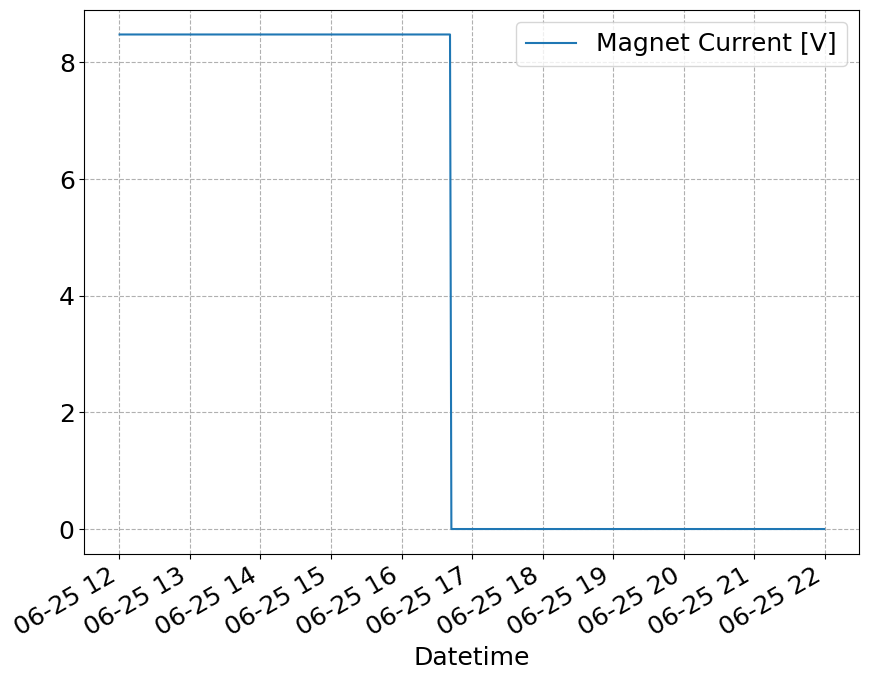

In [125]:
if 'Magnet Current [A]' in df.columns:
    ycol = 'Magnet Current [A]'
else:
    ycol = 'Magnet Current [V]'
df_.plot(y=ycol, use_index=True)

Text(0.5, 1.0, '2019-06-24 080033slow.txt')

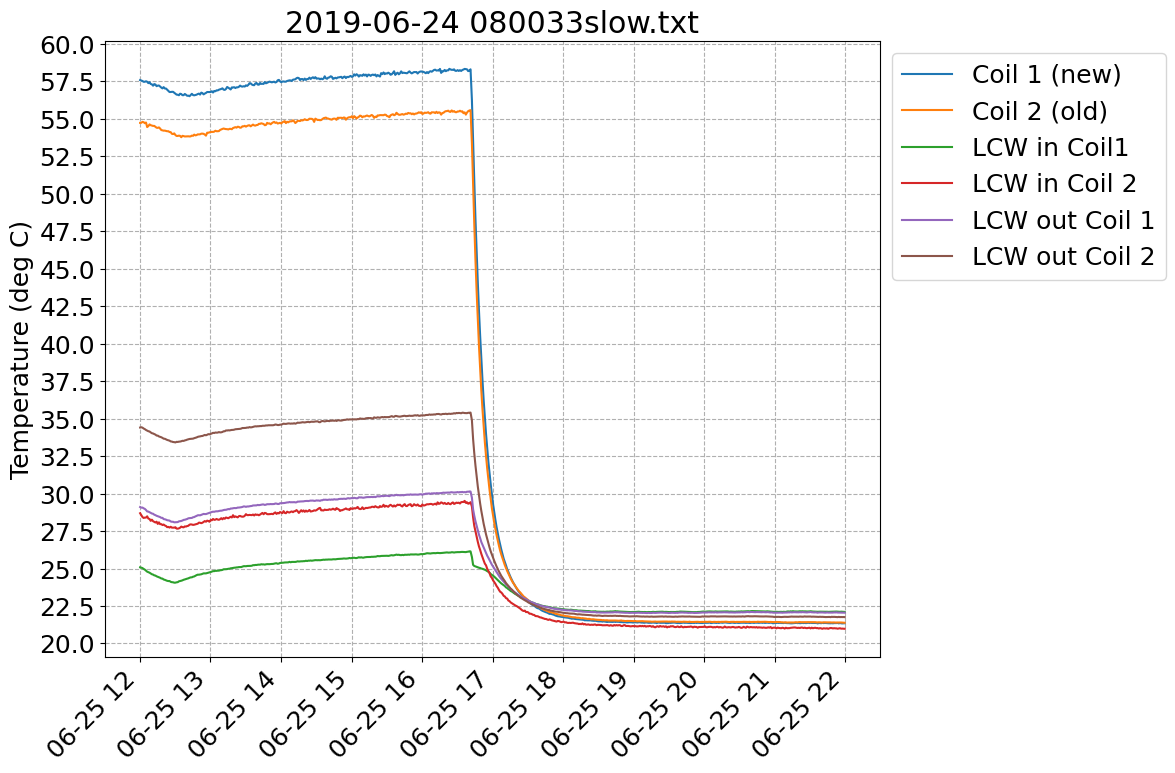

In [126]:
#temps = ['Coil 1 (new)', 'Coil 2 (old)']
temps = ['Coil 1 (new)', 'Coil 2 (old)', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']

fig, ax = plt.subplots()
for t in temps:
    vals = df_.loc[:, t]
    ax.plot(df_.index, vals, label=t)

# ax.xticks(rotation=90)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

ax.set_yticks(np.arange(20, 60+2.5, 2.5))

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax.set_ylabel("Temperature (deg C)")
ax.set_title(slowfile.split('/')[-1])

In [127]:
df_['NMR [T]'].max()

1.318598142

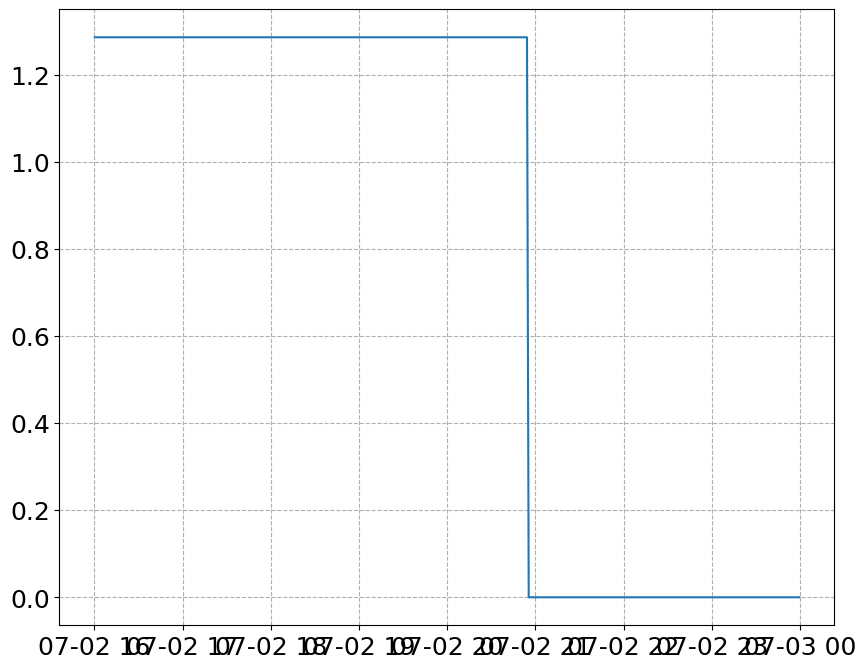

In [113]:
fig, ax = plt.subplots()

ax.plot(df_.index, df_['NMR [T]'])

In [49]:
df.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'Coil 1 (new)',
       'Coil 2 (old)', 'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2',
       'LCW out Coil 2', 'Yoke', 'Hall Element', 'Floor', 'Roof',
       'Yoke (center magnet)', 'Parameter HVAC sensor', 'Chamber Wall CH13',
       'Chamber Wall CH14', 'Chamber Wall CH15', 'Chamber Wall CH16',
       'Chamber Wall CH17', 'Chamber Wall CH18', 'Chamber Wall CH19',
       'Chamber Wall CH20', 'Desk Ambient', 'Outlet Strip Ambient',
       'Top fo Orange PS Ambient', 'Spare Ambient on desk',
       'TrippLite Ambient 3ft high', 'TrippLite Ambient Floor', 'PS internal',
       'PS Vent1', 'PS Vent2', 'TrippLite HVAC supply',
       'Tripplite HVAC exhaust', 'LCW to PS', 'LCW in barrel', 'ICW in',
       'ICW HE1 out', 'ICW He2 out', 'LCW return magnet', 'LCW to barrel',
       'LCW from PS', 'LCW to magnet', 'NMR [T]', 'NMR [FFT]',
       'DF0000000D5E803A_Raw_X', 'DF0000000D5E803A_Raw_Y',
       'DF0000000D5E803A_Raw_Z', 'C